In [1]:
import os
import sys
import warnings

Path = '/remote/tychodata/ftairli/work/Projects/Graph_FD_Reconstruction/Models'
if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')
    
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from Dataset2 import ProcessingDatasetContainer



ModuleNotFoundError: No module named 'Dataset2'

In [ ]:
Model_Names  = {'ThetaModel':'Model_SDP_Graph_JustTheta', 'PhiModel':'Model_SDP_Graph_JustPhi'}
Model_Name   = 'Model_SDP_Graph_Recombined'
Dataset_Name = 'Graph_Edges_Dataset'

#### Loading Data and Models, Processing Predictions

In [ ]:
Models_Path  = '/remote/tychodata/ftairli/work/Projects/Graph_FD_Reconstruction/Models'
Dataset_Path = '/remote/tychodata/ftairli/work/Projects/Graph_FD_Reconstruction/Data/'

In [ ]:
# Import Dataset Here

Dataset = torch.load(f'{Dataset_Path}/{Dataset_Name}.pt')
Dataset.AssignIndices()
Dataset.State = 'Test'

In [ ]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Dataset.State      = 'Test'
torch.cuda.empty_cache()
Dataset.BatchSize  = 64
Dataset.RandomIter = False

Pred_Theta  = []
Pred_Phi    = []
AuxData     = []
Truth = []
Rec   = []

# Compute Theta
Model = torch.load(f'{Models_Path}/{Model_Names["ThetaModel"]}.pt')
Model.to(device)
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        Truth     .append(BatchTruth)
        Pred_Theta.append(Model(BatchMains, BatchAux).cpu())
        Rec       .append(BatchRec)
        EvI+=1
Pred_Theta = torch.cat(Pred_Theta, dim=0)


# Compute Phi
Model = torch.load(f'{Models_Path}/{Model_Names["PhiModel"]}.pt')
Model.to(device)
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        Pred_Phi.append(Model(BatchMains, BatchAux).cpu())
        AuxData.append(BatchAux)
        EvI+=1
Pred_Phi = torch.cat(Pred_Phi, dim=0)

Truth = torch.cat(Truth, dim=0)
Rec   = torch.cat(Rec  , dim=0)

Pred = Pred_Theta + Pred_Phi

AuxData  = torch.cat(AuxData, dim=0)

print(Truth.shape)
print(AuxData.shape)
Truth = Dataset.Unnormalise_Truth(Truth, AuxData.squeeze())
Pred  = Dataset.Unnormalise_Truth(Pred , AuxData.squeeze())
Rec   = Dataset.Unnormalise_Truth(Rec  , AuxData.squeeze())

# drop NaN values
if True:
    # Looking for nans, sum up all of 2nd dim
    WeirdSum = Truth.sum(dim=1) + Pred.sum(dim=1) + Rec.sum(dim=1)
    Mask = ~torch.isnan(WeirdSum)
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]
    NanLocs = torch.where(Mask==0)
    print(f' Nan Locations {NanLocs}')

# Remove Bad events
if False:
    Mask = (torch.abs(Truth[:,0]-Rec[:,0]) < 1) & (torch.abs(Truth[:,1]-Rec[:,1]) < 1000)
    print(f'Dropping {len(Truth) - Mask.sum()} Bad events')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]


Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()


print(Truth.shape)
print(Pred.shape)



torch.Size([61620, 2])
torch.Size([61620, 1])
Dropping 0 NaN values
 Nan Locations (tensor([], dtype=torch.int64),)
(61620, 2)
(61620, 2)


In [ ]:
# Compute Metric
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

Pred68 = []
Rec68  = []

for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': 
        AngDivPred = np.arctan2(np.sin(Truth[:,i]-Pred[:,i]),np.cos(Truth[:,i]-Pred[:,i]))
        AngDivRec  = np.arctan2(np.sin(Truth[:,i]-Rec[:,i] ),np.cos(Truth[:,i]-Rec[:,i] ))
        Pred68.append(np.percentile(np.abs(AngDivPred),68))
        Rec68 .append(np.percentile(np.abs(AngDivRec ),68))
    elif TruthUnits[i] == 'deg':
        AngDivPred = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Pred[:,i])),np.cos(np.deg2rad(Truth[:,i]-Pred[:,i])))
        AngDivRec  = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Rec[:,i] )),np.cos(np.deg2rad(Truth[:,i]-Rec[:,i] )))
        Pred68.append(np.rad2deg(np.percentile(np.abs(AngDivPred),68)))
        Rec68 .append(np.rad2deg(np.percentile(np.abs(AngDivRec ),68)))
    else:
        Pred68.append(np.percentile(np.abs(Truth[:,i]-Pred[:,i]),68))
        Rec68 .append(np.percentile(np.abs(Truth[:,i]-Rec [:,i]),68))

# Print Out the values
    
for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': # Convert to degrees
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]*180/np.pi:.5} deg')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] *180/np.pi:.5} deg')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()
    else:
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]:.5} {TruthUnits[i]}')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] :.5} {TruthUnits[i]}')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()


Adjusted Percentile for Pred SDPTheta   0.66786 deg
Adjusted Percentile for Rec  SDPTheta   0.57651 deg
Percentile Ratio   Pred/Rec             1.1584

Adjusted Percentile for Pred SDPPhi     0.21287 deg
Adjusted Percentile for Rec  SDPPhi     0.17513 deg
Percentile Ratio   Pred/Rec             1.2156



#### Not particularly interesing plots

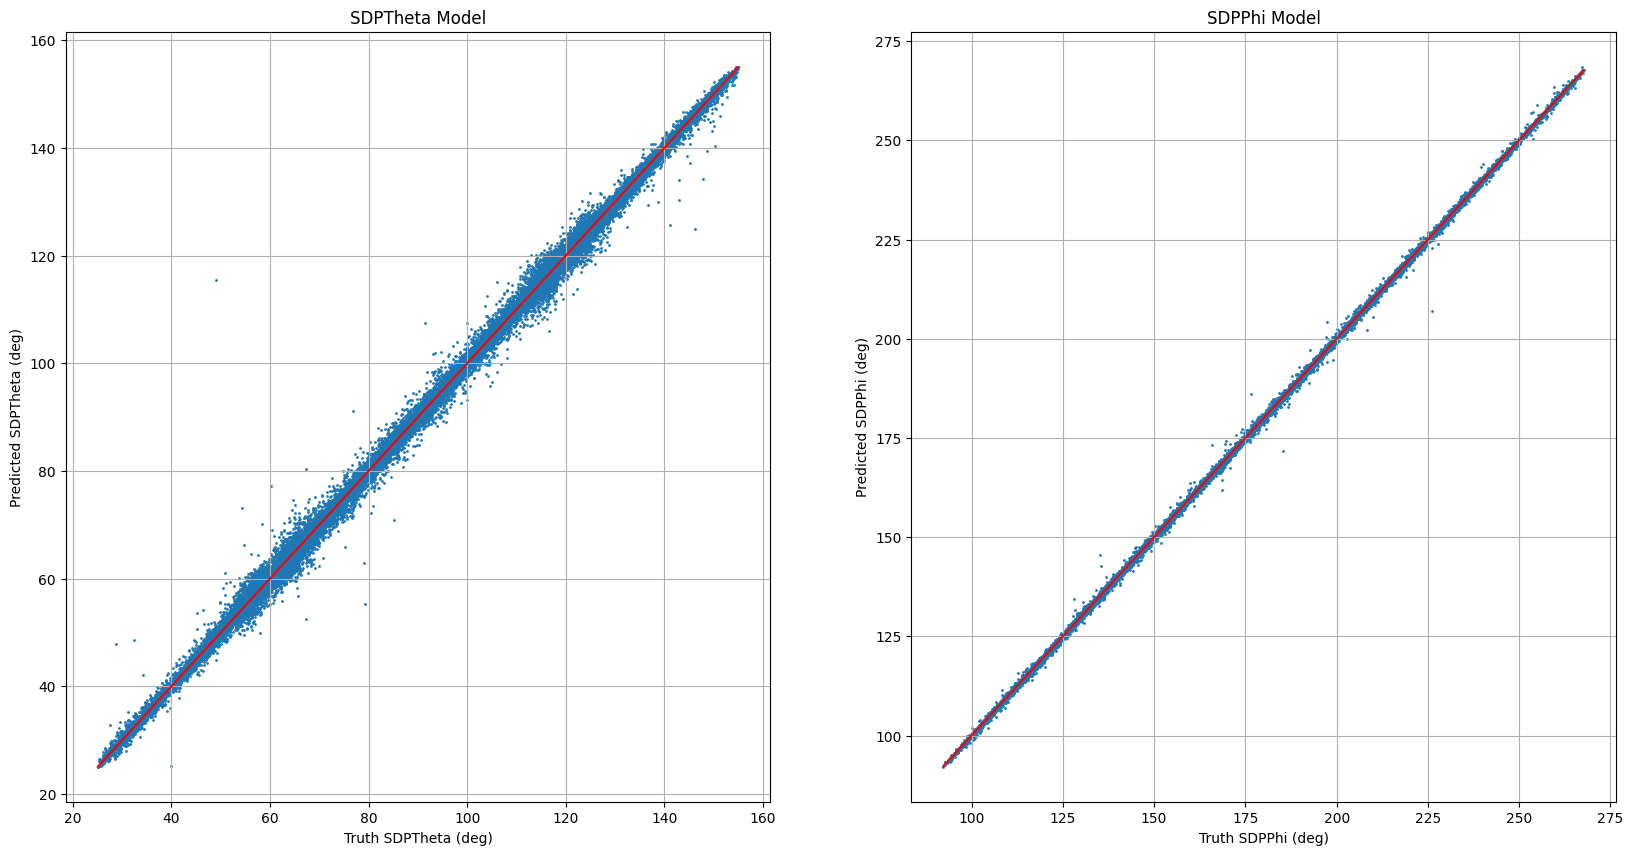

In [ ]:
# Easy Scatter Plots of Predicted vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Pred[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Model')
    ax[i].grid()

plt.show()


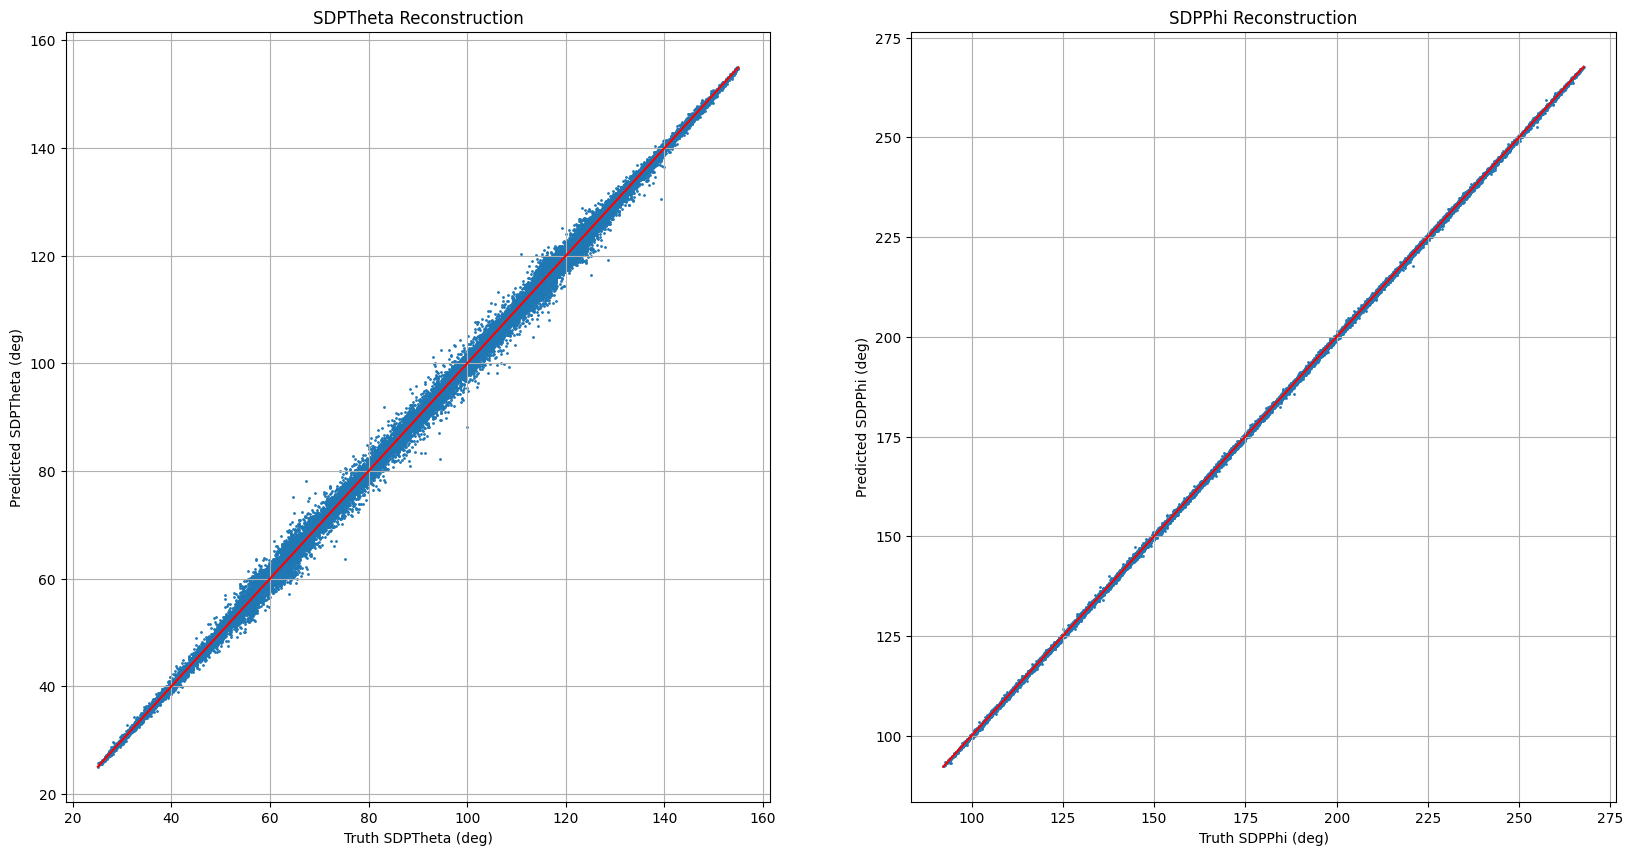

In [ ]:
# Easy Scatter Plots of Reconstructed vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Rec[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Reconstruction')
    ax[i].grid()

plt.show()


In [ ]:
# def DeviationPlot(TruthKeys,TruthUnits,Truth,Pred,Type):
#     fig, ax = plt.subplots(1, len(TruthKeys), figsize=(12.5*len(TruthKeys), 10))
#     for i in range(len(TruthKeys)):
#         X = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
#         Y = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        
        
#         # Scaling Cuts
#         if TruthKeys[i] == 'SDPTheta':
#             cut = (X > 0.1) & (np.abs(Y)<6)
#         elif TruthKeys[i] == 'SDPPhi':
#             cut = (np.abs(Y)<3) & (np.abs(X)<50)
#         elif TruthKeys[i] == 'Chi0':
#             cut = (np.abs(Y)<20)
#         elif TruthKeys[i] == 'Rp':
#             cut = (np.abs(Y)<5000)
#         elif TruthKeys[i] == 'T0':
#             cut = (np.abs(Y)<10000)
#         else:
#             cut = (np.abs(Y)>-1)


#         X = X[cut]
#         Y = Y[cut]

#         sns.scatterplot(x=X, y=Y, ax=ax[i], s=5,color='black')
#         sns.histplot(x=X, y=Y, ax=ax[i], bins=100, pthresh=0.1,cmap = 'inferno',cbar = True)
#         if TruthUnits[i] != 'rad': 
#             ax[i].set_ylabel(f'{Type}-Truth ({TruthUnits[i]})')
#             ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
            
#         else:                      
#             ax[i].set_ylabel(f'{Type}-Truth (degrees)')
#             ax[i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
#         ax[i].set_title(f'{TruthKeys[i]} - {Type}')
#         ax[i].set_xlim(min(X),max(X))
#         ax[i].grid()
#         # 68th Percentile
#         Percentile68 = np.percentile(np.abs(Y),68)
#         # Add as a texbox to top right of plot
#         if TruthUnits[i]!= 'rad': ax[i].text(0.95, 0.95, f'$\\sigma$: {Percentile68:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i].transAxes, fontsize=15)
#         else: ax[i].text(0.95, 0.95, f'$\\sigma$: {Percentile68:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i].transAxes, fontsize=15)

#         ax[i].axhline(Percentile68, color='cyan', linestyle='--')
#         ax[i].axhline(-Percentile68, color='cyan', linestyle='--')

#     return fig
    


In [ ]:
# # Deviation Plots
# TruthKeys  = Dataset.Truth_Keys
# TruthUnits = Dataset.Truth_Units

# ModelDeviation = DeviationPlot(TruthKeys,TruthUnits,Truth,Pred,'Model')
# RecDeviation   = DeviationPlot(TruthKeys,TruthUnits,Truth,Rec,'Reconstruction')

# # Save the Figures
# # ModelDeviation.savefig(f'../Results/{Name}_Model_Deviation.png')
# # RecDeviation  .savefig(f'../Results/{Name}_Rec_Deviation.png')

#### More Interesting plots

In [ ]:
# Colormap Truncation
from matplotlib.colors import LinearSegmentedColormap

# Create a truncated version of the inferno colormap (first 90%)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'truncated_{cmap.name}', 
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Original inferno colormap
inferno = plt.get_cmap('inferno_r')

# Truncated colormap: first 90%
truncated_inferno = truncate_colormap(inferno, 0.05, 1)


Total Points before cuts 61620
SDPTheta Total Points after cuts 59925
SDPPhi Total Points after cuts 60672


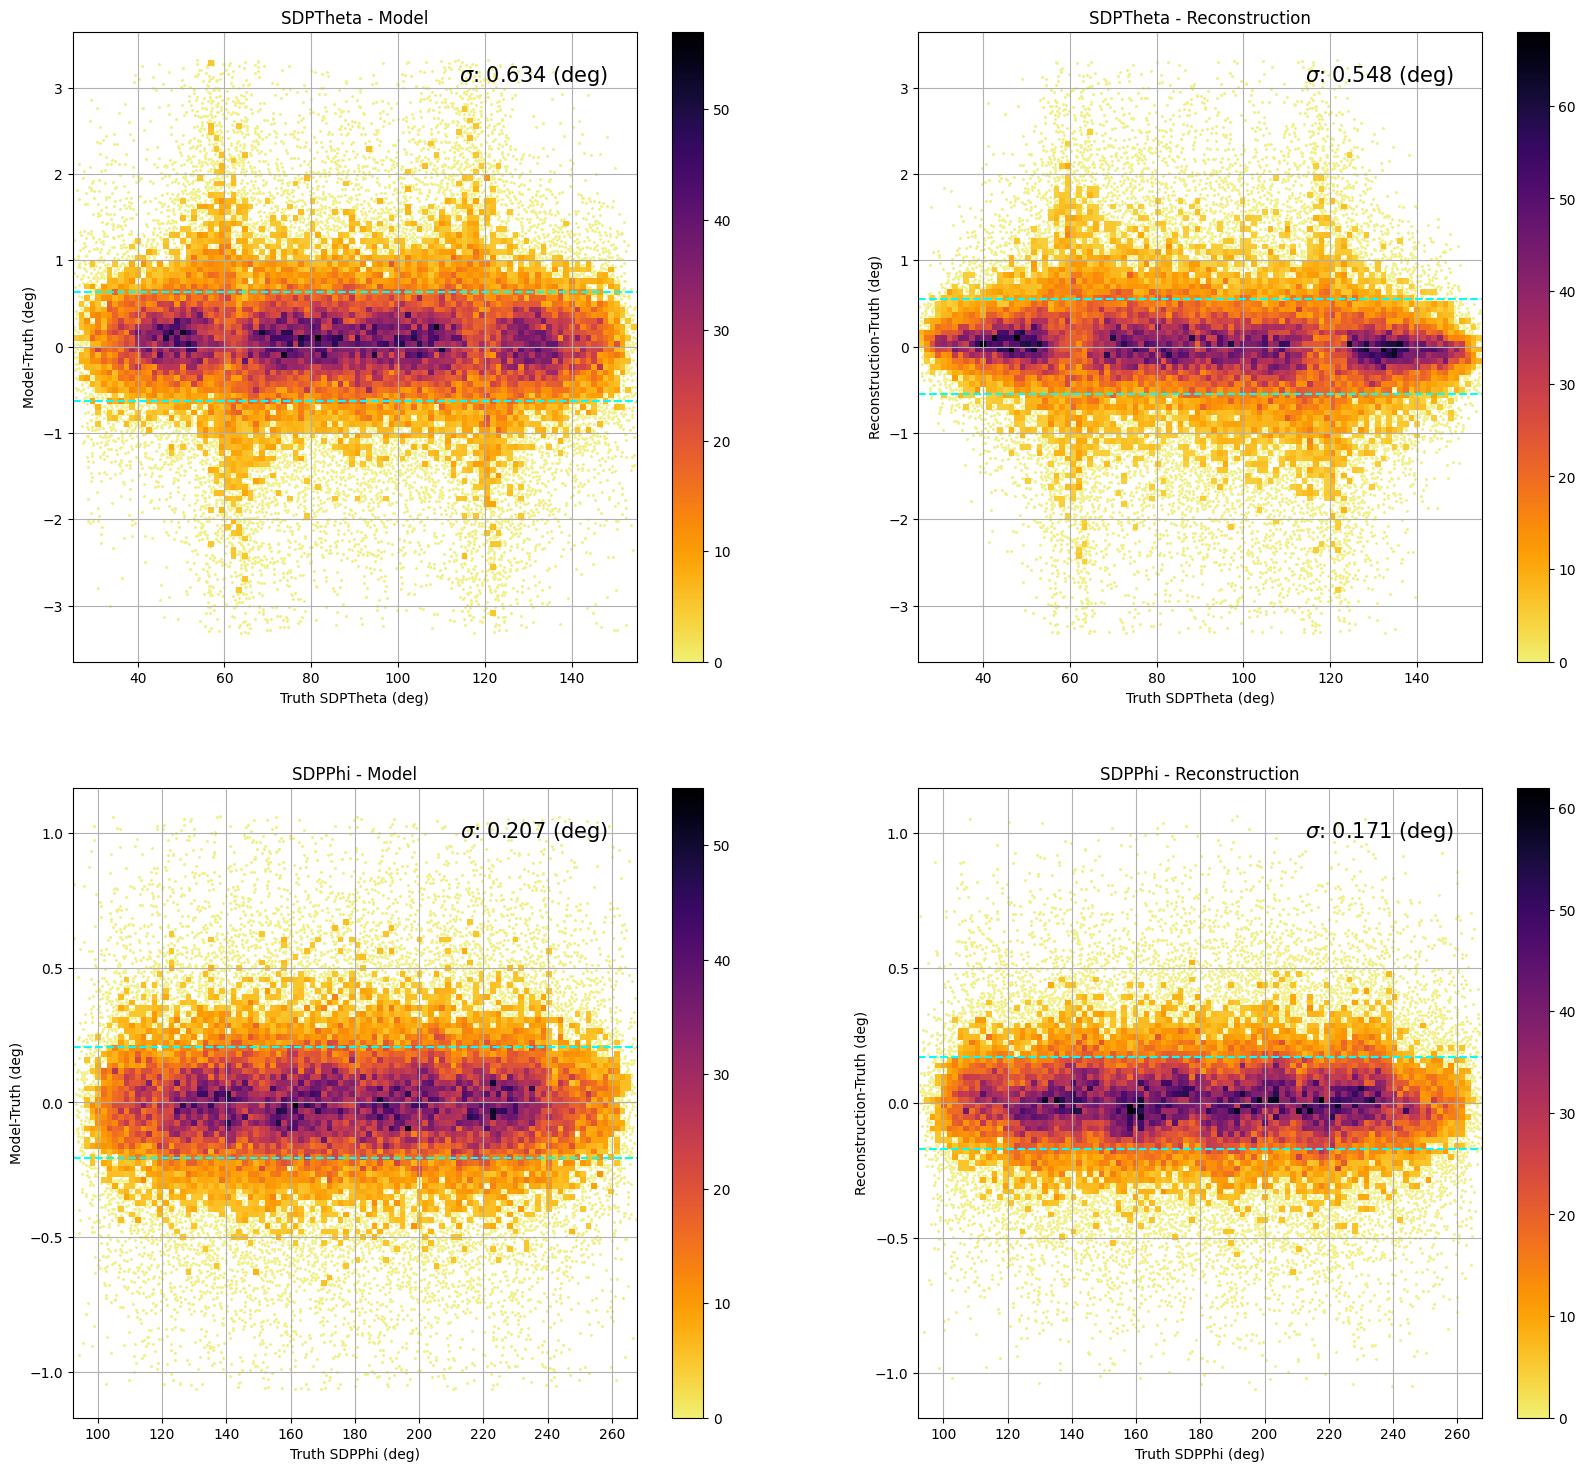

In [ ]:
def CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec):
    fig, ax = plt.subplots(len(TruthKeys),2, figsize=(20,9*len(TruthKeys)))
    print(f'Total Points before cuts {len(Truth)}')
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        if   TruthKeys[i] == 'SDPTheta': cut = (X > 0.1)          & (np.abs(Yp)<6)    & (np.abs(Yr)<6)
        elif TruthKeys[i] == 'SDPPhi'  : cut = (np.abs(Yp)<3)     & (np.abs(Yr)<3) #   & (np.abs(X)<50)
        elif TruthKeys[i] == 'Chi0'    : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'Rp'      : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'CEDist'  : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'T0'      : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        elif TruthKeys[i] == 'Xmax'    : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        elif TruthKeys[i] == 'LogE'    : cut = (X>0)              & (np.abs(Yp)<3)    & (np.abs(Yr)<3)
        elif TruthKeys[i] == 'z'       : cut = (X>0.4) 
        else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # Secondary Y_lim cuts for scaling
        Yp_STD = np.percentile(np.abs(Yp),68)
        cut = (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        X  = X [cut]
        Yp = Yp[cut]
        Yr = Yr[cut]
        print(f'{TruthKeys[i]} Total Points after cuts {len(X)}')
        # sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color='orange')
        # sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color='orange')

        sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color=truncated_inferno(0))
        sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color=truncated_inferno(0))


        sns.histplot(x=X, y=Yp, ax=ax[i,0], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[i,1], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[i,0].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[i,1].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[i,0].set_ylabel(f'Model-Truth (degrees)')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[i,1].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[i,0].set_title(f'{TruthKeys[i]} - Model')
        ax[i,1].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[i,0].set_xlim(min(X),max(X))
        ax[i,1].set_xlim(min(X),max(X))

        ax[i,0].grid()
        ax[i,1].grid()

        # ax[0,1].set_facecolor('lightgrey')
        # ax[1,1].set_facecolor('lightgrey')


        # 68th Percentile
        Percentile68_p = np.percentile(np.abs(Yp),68)
        Percentile68_r = np.percentile(np.abs(Yr),68)

        # ax[i,0].set_ylim(-Percentile68_p*5,Percentile68_p*5)
        # ax[i,1].set_ylim(-Percentile68_p*5,Percentile68_p*5)



        # Add as a texbox to top right of plot
        if TruthUnits[i]!= 'rad':
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)

        else:
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)



        ax[i,0].axhline(Percentile68_p, color='cyan', linestyle='--')
        ax[i,0].axhline(-Percentile68_p, color='cyan', linestyle='--')

        ax[i,1].axhline(Percentile68_r, color='cyan', linestyle='--')
        ax[i,1].axhline(-Percentile68_r, color='cyan', linestyle='--')
        
    return fig
    
figure = CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
figure.savefig(f'../Results/{Model_Name}_Combined_Deviation.png')

Total Points before cuts 61620
SDPTheta Total Points after cuts 61620
SDPPhi Total Points after cuts 61620


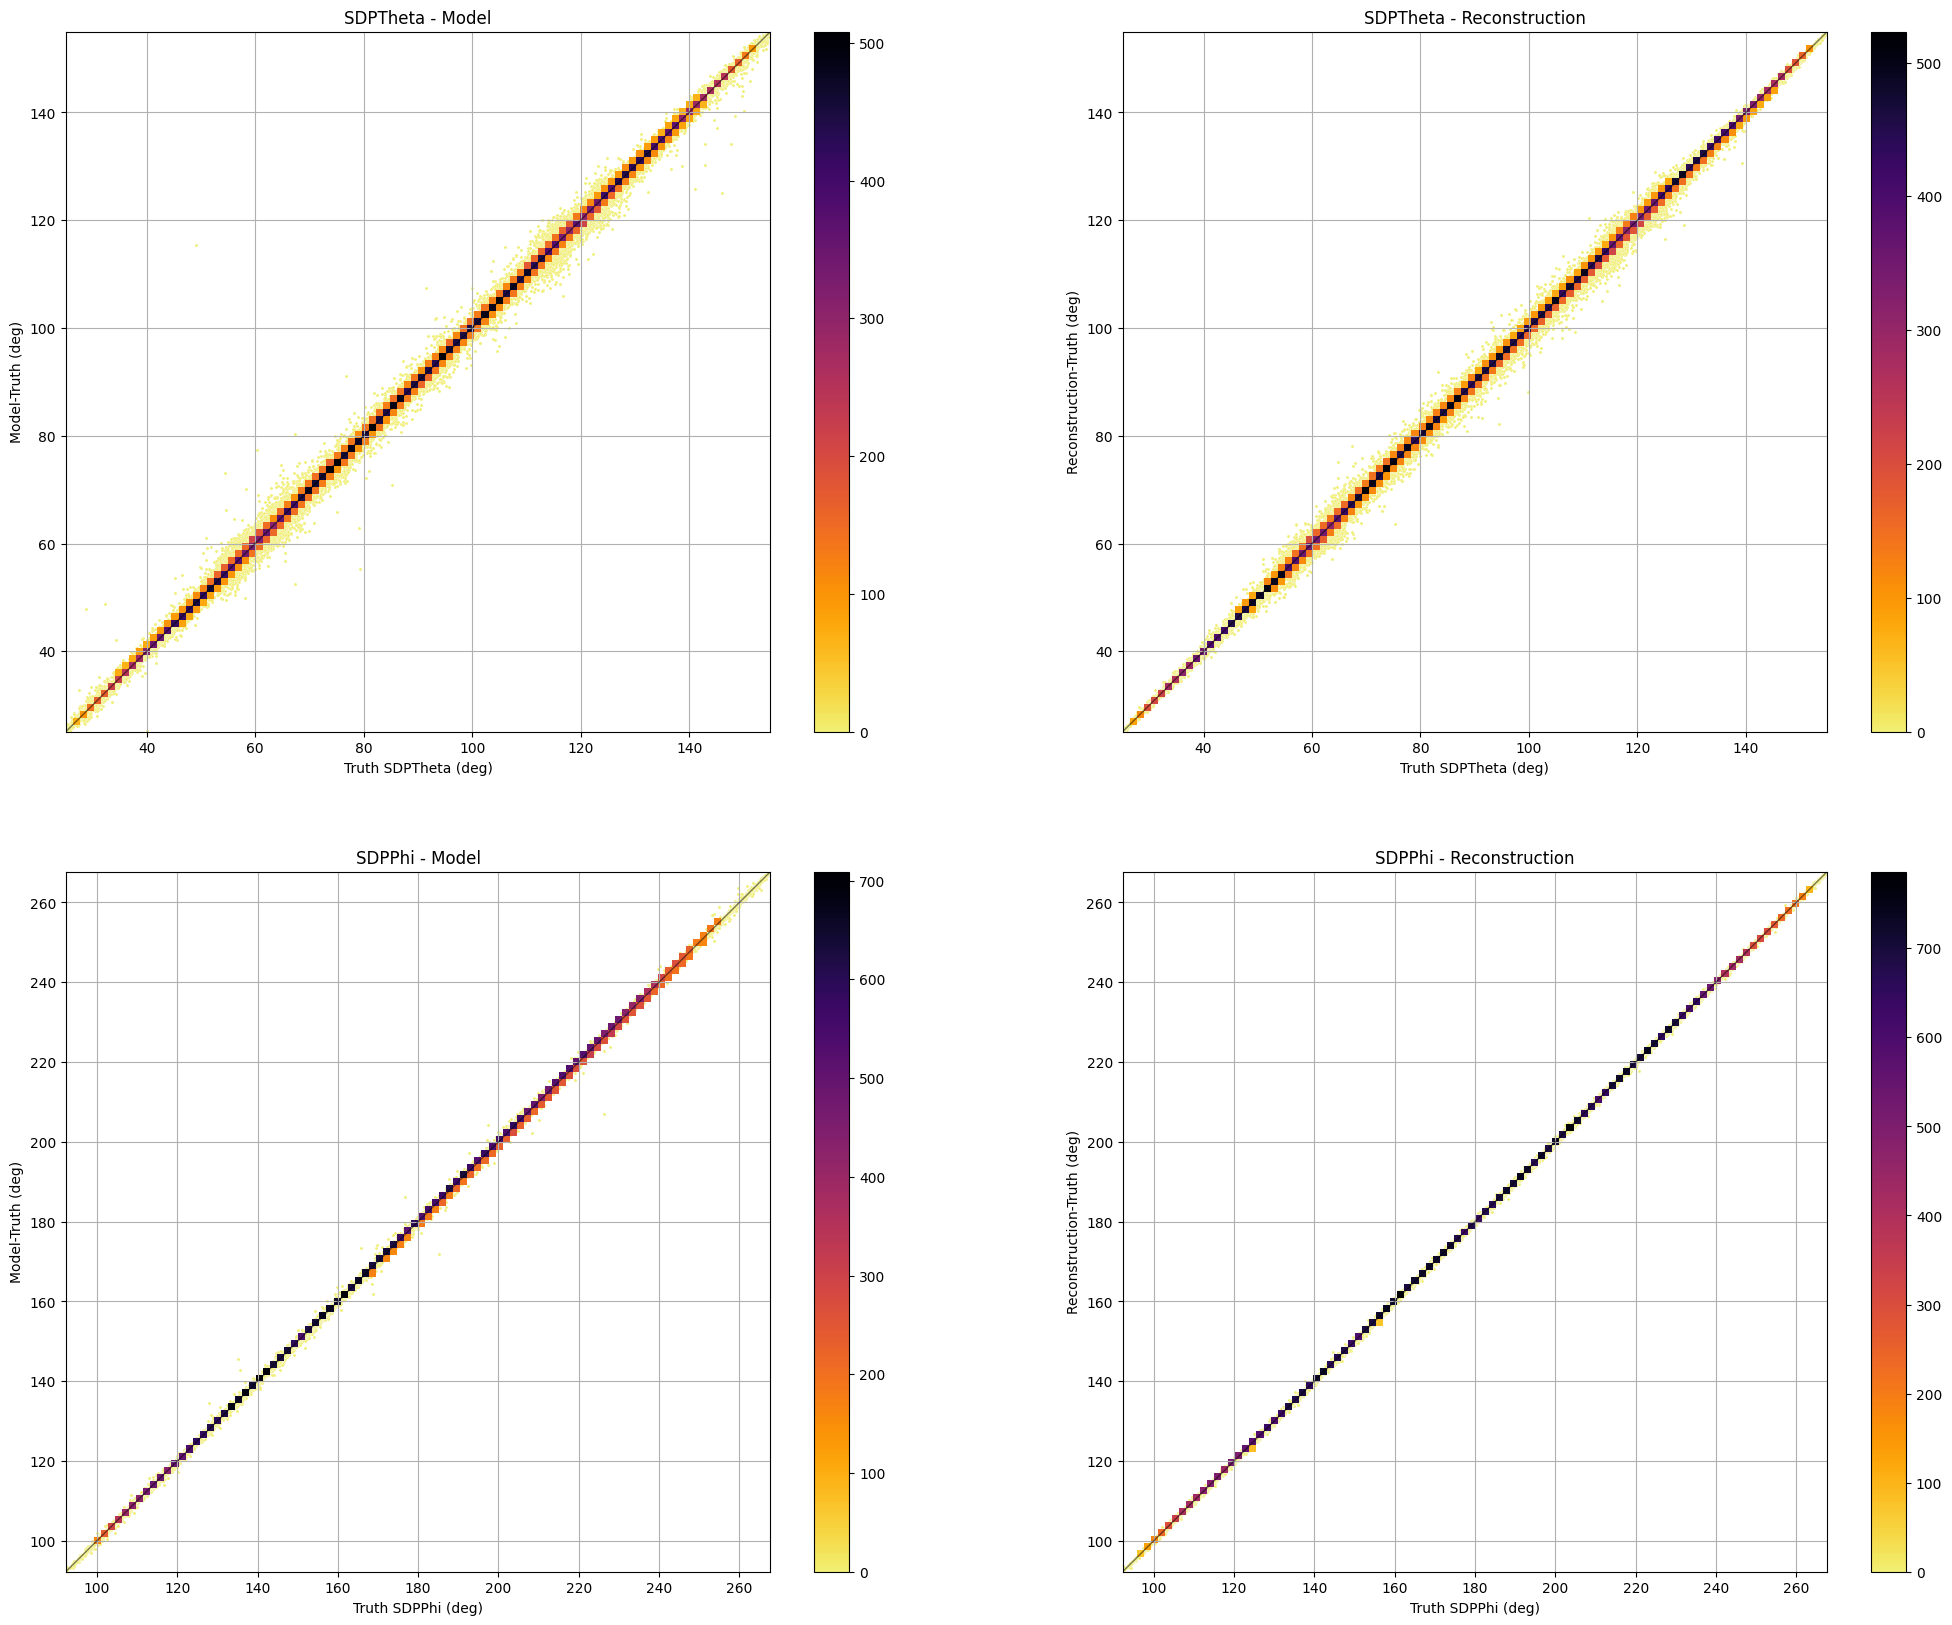

In [ ]:
def CombinedNonDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec,FaceColor='white'):
    fig, ax = plt.subplots(2, len(TruthKeys), figsize=(12.5*len(TruthKeys), 20))
    print(f'Total Points before cuts {len(Truth)}')
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        cut = (np.abs(Yp)>-1)
        # if TruthKeys[i] == 'SDPTheta': cut = (X > 0.1)          & (np.abs(Yp)<6)    & (np.abs(Yr)<6)
        # elif TruthKeys[i] == 'SDPPhi': cut = (np.abs(Yp)<3)     & (np.abs(Yr)<3)    & (np.abs(X)<50)
        # elif TruthKeys[i] == 'Chi0'  : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        # elif TruthKeys[i] == 'Rp'    : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        # elif TruthKeys[i] == 'CEDist': cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        # elif TruthKeys[i] == 'T0'    : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        # # elif TruthKeys[i] == 'Xmax'  : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        # elif TruthKeys[i] == 'LogE'  : cut = (X>0)              & (np.abs(Yp)<3)    & (np.abs(Yr)<3)
        # elif TruthKeys[i] == 'z'     : cut = (X>0.4) 
        # else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]
        print(f'{TruthKeys[i]} Total Points after cuts {len(X)}')
        # Secondary Y_lim cuts for scaling
        Yp_STD = np.percentile(np.abs(Yp),68)
        cut = (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color='orange')
        # sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color='orange')

        sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color=truncated_inferno(0))
        sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color=truncated_inferno(0))


        sns.histplot(x=X, y=Yp, ax=ax[i,0], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[i,1], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[i,0].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[i,1].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[i,0].set_ylabel(f'Model-Truth (degrees)')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[i,1].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[i,0].set_title(f'{TruthKeys[i]} - Model')
        ax[i,1].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[i,0].set_xlim(min(X),max(X))
        ax[i,1].set_xlim(min(X),max(X))

        ax[i,0].set_ylim(min(X),max(X))
        ax[i,1].set_ylim(min(X),max(X))


        ax[i,0].grid()
        ax[i,1].grid()


        # Truth Line

        ax[i,0].plot([min(X), max(X)], [min(X), max(X)], 'k',linewidth=1,alpha = 0.5)
        ax[i,1].plot([min(X), max(X)], [min(X), max(X)], 'k',linewidth=1,alpha = 0.5)


        ax[i,0].set_facecolor(FaceColor)
        ax[i,1].set_facecolor(FaceColor)

        
    return fig
    
figure = CombinedNonDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
figure.savefig(f'../Results/{Model_Name}_Combined_NonDeviation.png')

#### Other Plots

Sigma Pred:  0.7071836972236648
Sigma Rec :  0.6039314270019531


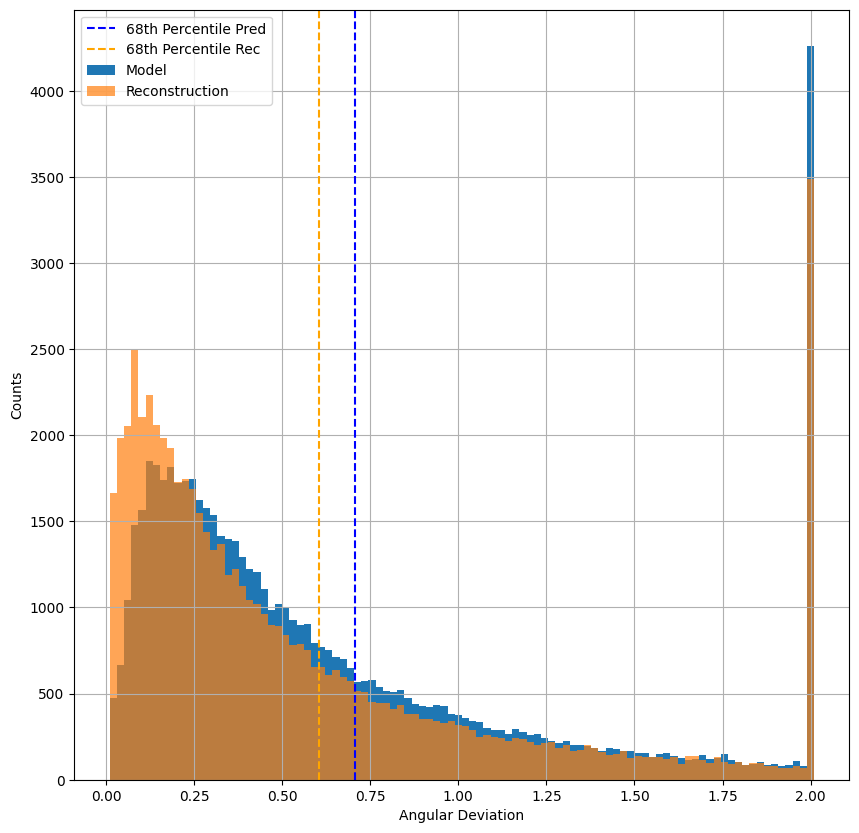

In [ ]:
# Angular Deviation of SDP

try:
    torch.tensor([1])
    SDPTheta_index =  TruthKeys.index('SDPTheta')
    SDPPhi_index   =  TruthKeys.index('SDPPhi')
    # Normalize the vectors to unit vectors
    def normalize_vectors(vectors):
        norms = np.linalg.norm(vectors, axis=1)
        return vectors / norms[:, np.newaxis]

    # Compute the angular deviation
    def compute_angular_deviation(truth, pred, rec):
        truth = normalize_vectors(truth)
        pred = normalize_vectors(pred)
        rec = normalize_vectors(rec)
        

        pred_dot_product = np.einsum('ij,ij->i', truth, pred)
        rec_dot_product = np.einsum('ij,ij->i', truth, rec)
        
        pred_ang_div = np.arccos(np.clip(pred_dot_product, -1.0, 1.0))
        rec_ang_div = np.arccos(np.clip(rec_dot_product, -1.0, 1.0))

        return pred_ang_div, rec_ang_div

    def angles_to_vector(Thetas,Phis):
        X = np.sin(Thetas)*np.cos(Phis)
        Y = np.sin(Thetas)*np.sin(Phis)
        Z = np.cos(Thetas)
        return np.array([X,Y,Z]).T




    Truth_Vecs = angles_to_vector(np.deg2rad(Truth[:,SDPTheta_index]),np.deg2rad(Truth[:,SDPPhi_index]))
    Pred_Vecs  = angles_to_vector(np.deg2rad(Pred [:,SDPTheta_index]),np.deg2rad(Pred [:,SDPPhi_index]))
    Rec_Vecs   = angles_to_vector(np.deg2rad(Rec  [:,SDPTheta_index]),np.deg2rad(Rec  [:,SDPPhi_index]))

    # Example usage
    angular_deviation_pred, angular_deviation_rec = compute_angular_deviation(Truth_Vecs, Pred_Vecs, Rec_Vecs)
    # Convert to deg
    angular_deviation_pred = np.rad2deg(angular_deviation_pred)
    angular_deviation_rec  = np.rad2deg(angular_deviation_rec)

    nbins =100
    Range = (0,2)

    bins = np.concatenate([np.linspace(Range[0], Range[1], nbins-1), [np.inf]])

    plt.figure(figsize=(10, 10)) 

    counts,bin_edges = np.histogram(angular_deviation_pred, bins=bins)
    counts[-2] += counts[-1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Model')

    counts,bin_edges = np.histogram(angular_deviation_rec, bins=bins)
    counts[-2] += counts[-1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Reconstruction', alpha=0.7)

    plt.axvline(np.percentile(angular_deviation_pred, 68), color='blue'  , linestyle='--', label='68th Percentile Pred')
    plt.axvline(np.percentile(angular_deviation_rec , 68), color='orange', linestyle='--', label='68th Percentile Rec')
    print('Sigma Pred: ',np.percentile(angular_deviation_pred, 68))
    print('Sigma Rec : ',np.percentile(angular_deviation_rec, 68))

    plt.xlabel('Angular Deviation')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()


except:
    pass


Model Values
Counts [734, 1449, 2202, 2695, 2582, 2805, 2632, 2570, 2393, 2348, 2117, 2083, 1906, 1813, 1602, 1511, 1481, 1345, 1302, 1168, 1150, 1011, 927, 860, 838, 796, 754, 748, 655, 630, 658, 588, 560, 518, 497, 429, 418, 429, 402, 395, 371, 309, 321, 303, 280, 262, 276, 255, 242, 235, 206, 233, 201, 172, 211, 172, 194, 197, 149, 134, 146, 135, 117, 159, 123, 134, 124, 124, 112, 109, 105, 109, 97, 92, 84, 86, 84, 90, 94, 87, 67, 78, 68, 73, 72, 61, 68, 61, 52, 66, 62, 61, 50, 55, 47, 56, 38, 37, 1613]
Bin Edges [0.0, 0.030612244897959183, 0.061224489795918366, 0.09183673469387754, 0.12244897959183673, 0.15306122448979592, 0.18367346938775508, 0.21428571428571427, 0.24489795918367346, 0.2755102040816326, 0.30612244897959184, 0.336734693877551, 0.36734693877551017, 0.3979591836734694, 0.42857142857142855, 0.45918367346938777, 0.4897959183673469, 0.5204081632653061, 0.5510204081632653, 0.5816326530612245, 0.6122448979591837, 0.6428571428571428, 0.673469387755102, 0.7040816326530612, 

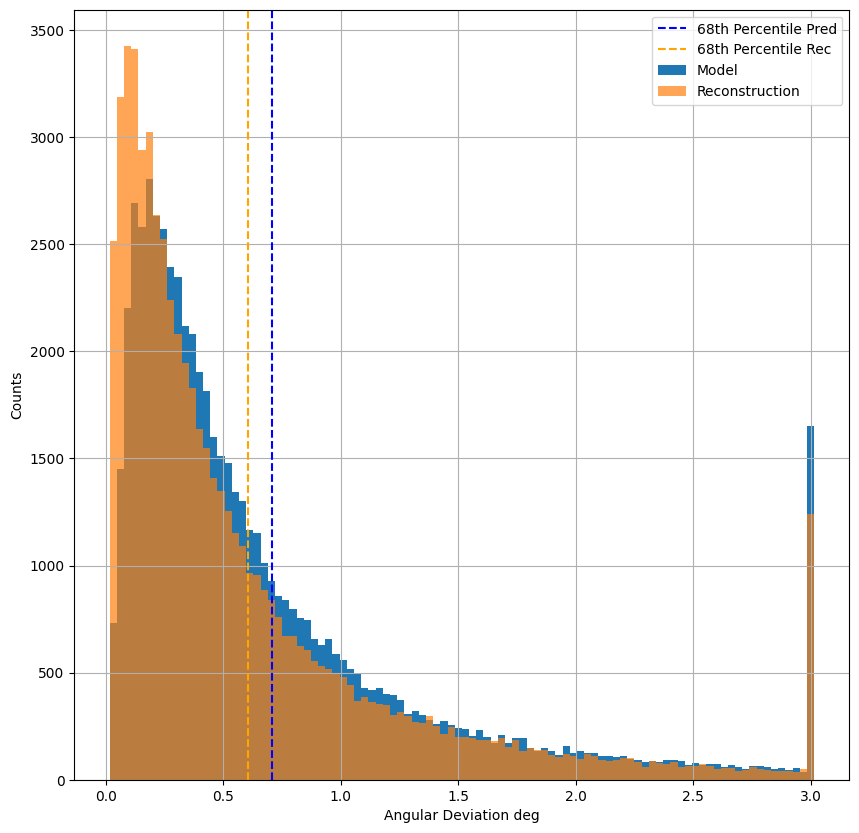

In [ ]:
# Standardised code

try:
    torch.tensor([1])
    SDPTheta_index =  TruthKeys.index('SDPTheta')
    SDPPhi_index   =  TruthKeys.index('SDPPhi')
    SDP_units      = TruthUnits[SDPTheta_index] if TruthUnits[SDPTheta_index] == TruthUnits[SDPPhi_index] else None
    assert SDP_units == 'rad' or SDP_units == 'deg', 'SDP units must be in radians or degrees'

    # Normalize the vectors to unit vectors
    def normalize_vectors(vectors):
        norms = np.linalg.norm(vectors, axis=1)
        return vectors / norms[:, np.newaxis]

    # Compute the angular deviation
    def compute_angular_deviation(truth, pred, rec):
        truth = normalize_vectors(truth)
        pred = normalize_vectors(pred)
        rec = normalize_vectors(rec)
        

        pred_dot_product = np.einsum('ij,ij->i', truth, pred)
        rec_dot_product = np.einsum('ij,ij->i', truth, rec)
        
        pred_ang_div = np.arccos(np.clip(pred_dot_product, -1.0, 1.0))
        rec_ang_div = np.arccos(np.clip(rec_dot_product, -1.0, 1.0))

        return pred_ang_div, rec_ang_div

    def angles_to_vector(Thetas,Phis):
        X = np.sin(Thetas)*np.cos(Phis)
        Y = np.sin(Thetas)*np.sin(Phis)
        Z = np.cos(Thetas)
        return np.array([X,Y,Z]).T



    if SDP_units == 'deg':
        Truth_Vecs = angles_to_vector(np.deg2rad(Truth[:,SDPTheta_index]),np.deg2rad(Truth[:,SDPPhi_index]))
        Pred_Vecs  = angles_to_vector(np.deg2rad(Pred [:,SDPTheta_index]),np.deg2rad(Pred [:,SDPPhi_index]))
        Rec_Vecs   = angles_to_vector(np.deg2rad(Rec  [:,SDPTheta_index]),np.deg2rad(Rec  [:,SDPPhi_index]))
    else:
        Truth_Vecs = angles_to_vector(Truth[:,SDPTheta_index],Truth[:,SDPPhi_index])
        Pred_Vecs  = angles_to_vector(Pred [:,SDPTheta_index],Pred [:,SDPPhi_index])
        Rec_Vecs   = angles_to_vector(Rec  [:,SDPTheta_index],Rec  [:,SDPPhi_index])

    # Example usage
    angular_deviation_pred, angular_deviation_rec = compute_angular_deviation(Truth_Vecs, Pred_Vecs, Rec_Vecs)
    # Convert to deg
    angular_deviation_pred = np.rad2deg(angular_deviation_pred)
    angular_deviation_rec  = np.rad2deg(angular_deviation_rec)

    nbins = 100
    Range = (0,3)

    bins = np.concatenate([np.linspace(Range[0], Range[1], nbins-1), [np.inf]])

    plt.figure(figsize=(10, 10)) 

    counts,bin_edges = np.histogram(angular_deviation_pred, bins=bins)
    print('Model Values')
    print('Counts',counts.tolist())
    print('Bin Edges',bin_edges.tolist())
    counts[-2] += counts[-1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Model')

    counts,bin_edges = np.histogram(angular_deviation_rec, bins=bins)
    print('Reconstruction Values')
    print('Counts',counts.tolist())
    print('Bin Edges',bin_edges.tolist())
    counts[-2] += counts[-1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Reconstruction', alpha=0.7)

    plt.axvline(np.percentile(angular_deviation_pred, 68), color='blue'  , linestyle='--', label='68th Percentile Pred')
    plt.axvline(np.percentile(angular_deviation_rec , 68), color='orange', linestyle='--', label='68th Percentile Rec')
    print('Sigma Pred: ',np.percentile(angular_deviation_pred, 68))
    print('Sigma Rec : ',np.percentile(angular_deviation_rec, 68))

    plt.xlabel(f'Angular Deviation {SDP_units}')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()


except:
    pass
